In [45]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from scipy.io import loadmat, savemat
import os
# from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import scipy.io as sio
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler,StandardScaler


dense_layers = [0, 1, 2, 3]
dense_sizes = [32, 64, 128, 256, 512]
conv_layers = [1, 2, 3, 4]
num_filters = [32, 64, 128, 256]
kernel_sizes = [2000, 2250, 2500, 2750, 3000]

In [32]:
basePath = 'random_single source_100snapshots_1000sample'

# UBUNTU path
filePath = '/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation'
#  MAC path:
# filePath = '/Users/button/Deeplearning-Autoencoder-DOA/data'
savePath = filePath + '/result'  + '/'+basePath

if not os.path.isdir(savePath):
    os.makedirs(savePath)
print(savePath)

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample


In [49]:
# Input train noisy dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(basePath+'/*/train/train_data.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['train_data']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list
len(data_set) 

data_train = data_set[0]
for i in data_set:
    data_train = np.vstack((data_train,i)) # stack all the datasets vertically
    
data_train = data_train[5000:] # the first dataset is included in twice
data_train.shape

(205000, 400)

In [50]:
# Input train noiseless dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(basePath + '/*/train/train_origin_data.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['train_origin_data']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list
len(data_set) 

data_origin = data_set[0]
for i in data_set:
    data_origin = np.vstack((data_origin,i)) # stack all the datasets vertically
    
data_origin = data_origin[5000:] # the first dataset is included in twice
data_origin.shape

(205000, 400)

In [51]:
# train data shuffle
np.random.seed(2020)
index = np.arange(data_train.shape[0])
print(index)
np.random.shuffle(index)
data_train = data_train[index]
data_origin = data_origin[index]

[     0      1      2 ... 204997 204998 204999]


In [52]:
## scaling
scaler = StandardScaler()
data_train_scale = scaler.fit_transform(np.transpose(data_train))
data_origin_scale = scaler.fit_transform(np.transpose(data_origin))
print(data_train_scale.shape)
print(data_origin_scale.shape)
data_train = np.transpose(data_train_scale)
data_origin = np.transpose(data_origin_scale)

(400, 205000)
(400, 205000)


In [53]:
# Model configuration
nSample = x_train.shape[0]
epoch = 100
batch_size = 64
validation_split = 0.2

save_dir = os.path.join(savePath, 'save_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
print(save_dir)

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample/save_models


In [54]:
class DOA_Denoising(Model):
    def __init__(self):
        super(DOA_Denoising, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(300, activation='relu'),
            # layers.Dropout(0.2),
            layers.Dense(200, activation='relu'),
            # layers.Dropout(0.2),
            layers.Dense(100, activation='relu')]) # * 300 200 100
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(200, activation='relu'), #* 200 300 400
            # layers.Dropout(0.2),
            layers.Dense(300, activation='relu'),
            # layers.Dropout(0.2),
            layers.Dense(400, activation='linear')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = DOA_Denoising() 

In [9]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

In [55]:
model_name = (
    f"epoch-{epoch}-batch-{batch_size}-dense-300-200-100-time-{int(time.time())}"
)
print(model_name)

file_path = os.path.join(save_dir, model_name)
print(file_path)

# callbacks_list
callbacks_list = [
    EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=50),
    ModelCheckpoint(
        filepath=file_path,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
    ),
    # TensorBoard(
    #     log_dir="./logs/{}".format(model_name),
    #     histogram_freq=1,
    #     write_graph=False,
    #     write_images=False,
    # ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=0,
        mode="min",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0,
    ),
]

autoencoder.compile(optimizer="adam", loss="mse")

epoch-100-batch-64-dense-300-200-100-time-1645807185
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample/save_models/epoch-100-batch-64-dense-300-200-100-time-1645807185


In [56]:
history = autoencoder.fit(
    # dataset_final.take(num_train),
    data_train,
    data_origin,
    epochs=epoch,
    batch_size=batch_size,
    shuffle=True,
    # validation_data = dataset_final.skip(205000*0.8),
    validation_split=validation_split,
    callbacks=callbacks_list,  #! Do not put [] around callbacks_list variable
)

autoencoder.encoder.summary()
autoencoder.decoder.summary()

Epoch 1/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.1779 - val_loss: 0.1483
Epoch 2/100
2563/2563 [==============================] - 6s 2ms/step - loss: 0.1432 - val_loss: 0.1432
Epoch 3/100
2563/2563 [==============================] - 6s 2ms/step - loss: 0.1358 - val_loss: 0.1425
Epoch 4/100
2563/2563 [==============================] - 6s 2ms/step - loss: 0.1312 - val_loss: 0.1438
Epoch 5/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.1270 - val_loss: 0.1430
Epoch 6/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.1233 - val_loss: 0.1441
Epoch 7/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.1202 - val_loss: 0.1432
Epoch 8/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.1168 - val_loss: 0.1437
Epoch 9/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.1143 - val_loss: 0.1395
Epoch 10/100
2563/2563 [==============================] - 7s 3ms/step - l

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history["loss"], label="Traing Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
# plt.savefig('10.png')
# plt.savefig('SNR_-30_training_loss.png')

NameError: name 'history' is not defined

In [57]:
# Input test noisy dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(basePath + '/20dB/test/test_data.*', shuffle=False)
for i in dataset.as_numpy_iterator():
    print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['test_data']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list
len(data_set) 
data_test = data_set[0]
for i in data_set:
    data_test = np.vstack((data_test,i)) # stack all the datasets vertically
data_test = data_test[1000:] # the first dataset is included in twice

b'random_single source_100snapshots_1000sample/20dB/test/test_data.mat'


In [58]:
# scaling
# data_test = scaler.fit_transform(data_test)
data_test_scale = scaler.fit_transform(np.transpose(data_test))
# print(data_test_scale.shape)
data_test = np.transpose(data_test_scale)
# print(data_test.shape)

# export data for MATLAB processing
print(savePath)
savePath_ = savePath + '/test_data.mat'
print(savePath_)
savemat(savePath_, {'test_data':data_test})

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample/test_data.mat


(1000, 100)
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample/denoised_data.mat


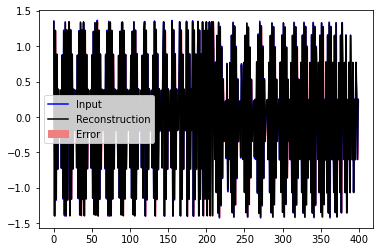

In [59]:
encoded_data = autoencoder.encoder(data_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()
print(encoded_data.shape)

# Save the denoised data for MATLAB processing
print(savePath)
savePath_ = savePath + '/denoised_data.mat'
print(savePath_)
savemat(savePath_, {'denoised_data':decoded_data})

ind = 40
plt.plot(data_test[ind],'b')
plt.plot(decoded_data[ind],'k')
plt.fill_between(np.arange(400),decoded_data[ind],data_test[ind],color='lightcoral')
plt.legend(["Input", "Reconstruction","Error"])
# plt.savefig('SNR_-30_autoencoder_compare.png')

In [60]:
# Input test label dataset for all snr and stack them together
dataset = tf.data.Dataset.list_files(basePath + '/20dB/test/test_label.*', shuffle=False)
# for i in dataset.as_numpy_iterator():
#     print(i)
data_set = []
for i in dataset.as_numpy_iterator():
    x_train = sio.loadmat(i)
    x_train = x_train['test_label']  # noisy sample covariance matrix
    data_set.append(x_train) #NOTE: put all the train_data of different SNR into one list
len(data_set) 
data_label = data_set[0]
for i in data_set:
    data_label = np.vstack((data_label,i)) # stack all the datasets vertically
data_label = data_label[1000:] # the first dataset is included in twice
data_label.shape

print(savePath)
savePath_ = savePath + '/test_label.mat'
print(savePath_)
savemat(savePath_, {'test_label':data_label})

/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample
/home/hymc/[0]Github/Deeplearning-Autoencoder-DOA/[2]Tensorflow/[1]DAE_DOA_implementation/result/random_single source_100snapshots_1000sample/test_label.mat


In [17]:
# x_test = sio.loadmat('vec')
# test_max = x_test['vec']
# test_max = test_max.reshape(1,64)
# test_max.shape

(1, 64)

In [ ]:

# encoded_data = autoencoder.encoder(test_max).numpy()
# decoded_data = autoencoder.decoder(encoded_data).numpy()
# print(encoded_data.shape)

# # Save the denoised data for MATLAB processing
# print(savePath)
# savePath_ = savePath + '/denoised_data.mat'
# print(savePath_)
# savemat(savePath_, {'denoised_data':decoded_data})
